# What am I Investigating?
Tennis is a racquet sport that can be played individually against a single opponent (singles) or between two teams of two players each (doubles). Players use a strung racquet to strike a hollow rubber ball, covered with felt, over a net and into the opponent's court. The objective of the game is to play the ball in such a way that the opponent cannot play a valid return. The player who is unable to return the ball will not gain a point, while the opposite player will.  
Tennis is played on different surfaces, including grass, clay, hard courts, and even indoor carpet. Each surface affects the ball's speed and bounce differently, leading to varied styles of play.  
*I'm intrested to find out if there's a relationship between the surface the match was played on and its duration*.

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, kurtosis

pd.set_option('display.max_columns', 50)

# Loading Data

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [3]:
combined_df.sample(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
3102,1991-328,Basel,Hard,32,A,19910923,31,101084,6.0,NaN,Jakob Hlasek,R,188.0,SUI,26.8,100581,8.0,NaN,John McEnroe,L,180.0,USA,32.5,7-6(4) 6-0 6-3,5,F,129.0,11.0,1.0,85.0,54.0,44.0,18.0,14.0,1.0,2.0,7.0,5.0,86.0,44.0,32.0,16.0,13.0,4.0,9.0,18.0,1134.0,25.0,922.0
27931,1998-499,Coral Springs,Clay,32,A,19980504,27,102394,NaN,NaN,Johan Van Herck,R,185.0,BEL,23.9,101833,NaN,NaN,Michael Tebbutt,L,190.0,AUS,27.3,6-1 6-4,3,QF,61.0,2.0,3.0,37.0,23.0,17.0,9.0,8.0,0.0,2.0,5.0,10.0,64.0,25.0,16.0,13.0,9.0,3.0,9.0,97.0,491.0,98.0,488.0
16437,1995-426,Johannesburg,Hard,32,A,19950403,18,101703,8.0,NaN,Guillaume Raoux,R,180.0,FRA,25.1,101432,NaN,NaN,Dimitri Poliakov,R,183.0,UKR,27.2,7-6(2) 7-5,3,R16,91.0,10.0,3.0,73.0,32.0,29.0,22.0,12.0,4.0,6.0,7.0,5.0,90.0,50.0,35.0,19.0,12.0,13.0,16.0,113.0,424.0,179.0,230.0
51928,2005-506,Buenos Aires,Clay,32,A,20050207,11,103252,NaN,NaN,Alberto Martin,R,175.0,ESP,26.4,103970,NaN,NaN,David Ferrer,R,175.0,ESP,22.8,5-0 RET,3,R32,22.0,0.0,2.0,16.0,4.0,3.0,9.0,3.0,0.0,0.0,1.0,3.0,15.0,7.0,3.0,2.0,2.0,0.0,2.0,69.0,543.0,47.0,795.0
33993,2000-336,Hong Kong,Hard,32,A,20001002,27,103017,3.0,NaN,Nicolas Kiefer,R,183.0,GER,23.2,102839,5.0,NaN,Nicolas Lapentti,R,188.0,ECU,24.1,6-2 6-4,3,QF,83.0,8.0,3.0,60.0,29.0,25.0,14.0,9.0,3.0,4.0,4.0,2.0,53.0,32.0,19.0,9.0,9.0,6.0,10.0,13.0,1580.0,16.0,1378.0
85560,2016-M-DC-2016-WG-M-GBR-SRB-01,Davis Cup WG QF: GBR vs SRB,Clay,4,D,20160715,1,106378,NaN,NaN,Kyle Edmund,R,188.0,GBR,21.5,104386,NaN,NaN,Janko Tipsarevic,R,180.0,SRB,32.0,6-3 6-4 6-0,3,RR,111.0,5.0,3.0,77.0,39.0,32.0,24.0,13.0,3.0,4.0,4.0,3.0,75.0,43.0,24.0,13.0,12.0,3.0,9.0,67.0,768.0,405.0,103.0
53263,2006-301,Auckland,Hard,32,A,20060109,18,104339,5.0,NaN,Mario Ancic,R,196.0,CRO,21.7,104918,NaN,NaN,Andy Murray,R,190.0,GBR,18.6,6-3 7-6(4),3,R16,95.0,6.0,2.0,80.0,48.0,36.0,16.0,11.0,8.0,10.0,1.0,4.0,62.0,32.0,22.0,17.0,10.0,2.0,5.0,21.0,1360.0,62.0,582.0
89510,2018-M020,Brisbane,Hard,32,A,20180101,286,105992,NaN,NaN,Ryan Harrison,R,183.0,USA,25.6,105870,NaN,LL,Yannick Hanfmann,R,193.0,GER,26.1,6-7(5) 6-4 6-2,3,R16,145.0,19.0,5.0,96.0,54.0,43.0,23.0,15.0,8.0,9.0,5.0,5.0,115.0,68.0,50.0,17.0,15.0,7.0,11.0,47.0,1010.0,119.0,499.0
167,1991-580,Australian Open,Hard,128,G,19910114,44,101990,NaN,NaN,Richard Krajicek,R,196.0,NED,19.1,102148,NaN,NaN,Fabrice Santoro,R,178.0,FRA,18.0,2-6 6-1 6-2 6-3,5,R128,122.0,9.0,3.0,97.0,48.0,35.0,26.0,16.0,3.0,6.0,1.0,3.0,114.0,74.0,43.0,18.0,16.0,11.0,18.0,113.0,307.0,46.0,611.0
70164,2011-615,Dusseldorf,Clay,32,A,20110515,17,103428,NaN,NaN,Juan Ignacio Chela,R,190.0,ARG,31.7,104545,NaN,NaN,John Isner,R,206.0,USA,26.0,6-1 7-6(1),3,RR,92.0,0.0,1.0,73.0,62.0,43.0,7.0,9.0,5.0,5.0,1.0,0.0,62.0,34.0,20.0,14.0,10.0,4.0,7.0,43.0,1055.0,39.0,1070.0


# Understanding the Big Picture

Getting the number of rows and columns in the dataset (pre-cleaning):

In [4]:
number_of_rows_pre_cleaning = combined_df.shape[0]
number_of_columns_pre_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_pre_cleaning} rows and {number_of_columns_pre_cleaning} columns.")

The dataset has 104682 rows and 49 columns.


Counting the number of NA's in each column:

In [5]:
combined_df.isna().sum()

tourney_id                0
tourney_name              0
surface                   0
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           62282
winner_entry          91873
winner_name               0
winner_hand               9
winner_ht              2454
winner_ioc                0
winner_age                5
loser_id                  0
loser_seed            81382
loser_entry           83599
loser_name                0
loser_hand               42
loser_ht               4855
loser_ioc                 0
loser_age                18
score                     0
best_of                   0
round                     0
minutes               13036
w_ace                 10207
w_df                  10207
w_svpt                10207
w_1stIn               10207
w_1stWon              10207
w_2ndWon              10207
w_SvGms               10206
w_bpSaved             10207
w_bpFaced           

Checking if there are any duplicate rows:

In [6]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

Deleting matches that we don't know their statistics:

In [7]:
match_data_columns_names = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced"]

combined_df.dropna(subset=match_data_columns_names, inplace=True)

combined_df[match_data_columns_names].isna().sum() # If the code above worked, the columns in the list above should have 0 NA's.

w_ace        0
w_df         0
w_svpt       0
w_1stIn      0
w_1stWon     0
w_2ndWon     0
w_SvGms      0
w_bpSaved    0
w_bpFaced    0
l_ace        0
l_df         0
l_svpt       0
l_1stIn      0
l_1stWon     0
l_2ndWon     0
l_SvGms      0
l_bpSaved    0
l_bpFaced    0
dtype: int64

Deleting unnecessary columns:

In [8]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"]

combined_df.drop(columns=names_of_columns_to_drop, inplace=True)

combined_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'winner_id', 'winner_name', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_age', 'loser_id', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [9]:
combined_df['tourney_date'] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df['tourney_date'].head()

0   1990-12-31
1   1990-12-31
2   1990-12-31
3   1990-12-31
4   1990-12-31
Name: tourney_date, dtype: datetime64[ns]

Creating new columns:

In [10]:
# Creating a variable called "total_points" - the total points played in the match.
combined_df["total_points"] = combined_df["w_svpt"] + combined_df["l_svpt"]

combined_df.sample(7)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,total_points
38569,2001-438,Moscow,Carpet,32,A,2001-10-01,103017,Nicolas Kiefer,R,183.0,GER,24.2,101820,Marc Rosset,R,201.0,SUI,30.8,6-3 7-6(1),3,QF,129.0,7.0,5.0,104.0,60.0,42.0,19.0,11.0,11.0,13.0,10.0,11.0,66.0,34.0,24.0,12.0,10.0,4.0,7.0,39.0,910.0,103.0,420.0,170.0
79294,2014-520,Roland Garros,Clay,128,G,2014-05-26,104871,Jeremy Chardy,R,188.0,FRA,27.2,104593,Daniel Gimeno Traver,R,185.0,ESP,28.7,7-5 6-2 6-2,5,R128,97.0,10.0,3.0,74.0,49.0,39.0,16.0,14.0,2.0,3.0,1.0,3.0,83.0,49.0,30.0,15.0,14.0,2.0,8.0,42.0,1060.0,94.0,599.0,157.0
60295,2008-352,Paris Masters,Hard,48,M,2008-10-26,103819,Roger Federer,R,185.0,SUI,27.2,104417,Robin Soderling,R,193.0,SWE,24.2,6-4 7-6(7),3,R32,75.0,10.0,0.0,60.0,42.0,38.0,12.0,11.0,0.0,0.0,5.0,1.0,68.0,44.0,34.0,13.0,11.0,1.0,2.0,2.0,5805.0,18.0,1290.0,128.0
44489,2003-414,Hamburg Masters,Clay,64,M,2003-05-12,102227,Sargis Sargsian,R,180.0,ARM,29.9,103103,Dominik Hrbaty,R,183.0,SVK,25.3,6-7(4) 6-4 6-4,3,R64,129.0,2.0,6.0,106.0,60.0,39.0,26.0,16.0,6.0,10.0,7.0,7.0,101.0,55.0,36.0,24.0,16.0,5.0,11.0,72.0,578.0,59.0,697.0,207.0
37376,2001-337,Vienna,Hard,32,A,2001-10-08,102450,Tim Henman,R,185.0,GBR,27.0,101965,Wayne Ferreira,R,185.0,RSA,30.0,6-4 6-0,3,R32,70.0,1.0,1.0,51.0,33.0,25.0,7.0,8.0,3.0,4.0,1.0,2.0,50.0,28.0,18.0,4.0,8.0,1.0,6.0,8.0,2200.0,35.0,995.0,101.0
89107,2017-7581,Chengdu,Hard,32,A,2017-09-25,104797,Denis Istomin,R,188.0,UZB,31.0,111575,Karen Khachanov,R,198.0,RUS,21.3,6-3 6-2,3,R16,64.0,8.0,0.0,53.0,34.0,29.0,10.0,9.0,3.0,3.0,3.0,5.0,50.0,19.0,16.0,12.0,8.0,3.0,6.0,78.0,671.0,32.0,1330.0,103.0
7653,1993-494,Jakarta,Hard,32,A,1993-01-11,101234,Patrik Kuhnen,R,190.0,GER,26.9,101717,Diego Nargiso,L,188.0,ITA,22.8,7-6(2) 6-4,3,R32,116.0,2.0,2.0,77.0,40.0,29.0,23.0,11.0,2.0,3.0,6.0,6.0,80.0,42.0,29.0,19.0,11.0,5.0,7.0,81.0,474.0,100.0,406.0,157.0


Getting the number of rows and columns in the dataset (post-cleaning):

In [11]:
number_of_rows_post_cleaning = combined_df.shape[0]
number_of_columns_post_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_post_cleaning} rows and {number_of_columns_post_cleaning} columns.")
print(f"{number_of_rows_pre_cleaning-number_of_rows_post_cleaning} rows were deleted and {number_of_columns_pre_cleaning-number_of_columns_post_cleaning} were removed.")

The dataset has 94475 rows and 45 columns.
10207 rows were deleted and 4 were removed.


# Univariate Analysis

## Categorical Variables

### Surface Type

Counting the number of games played on each surface:

In [14]:
combined_df["surface"].value_counts()

Hard      47729
Clay      31085
Grass      9783
Carpet     5878
Name: surface, dtype: int64

Plotting the number of games played on each surface type:

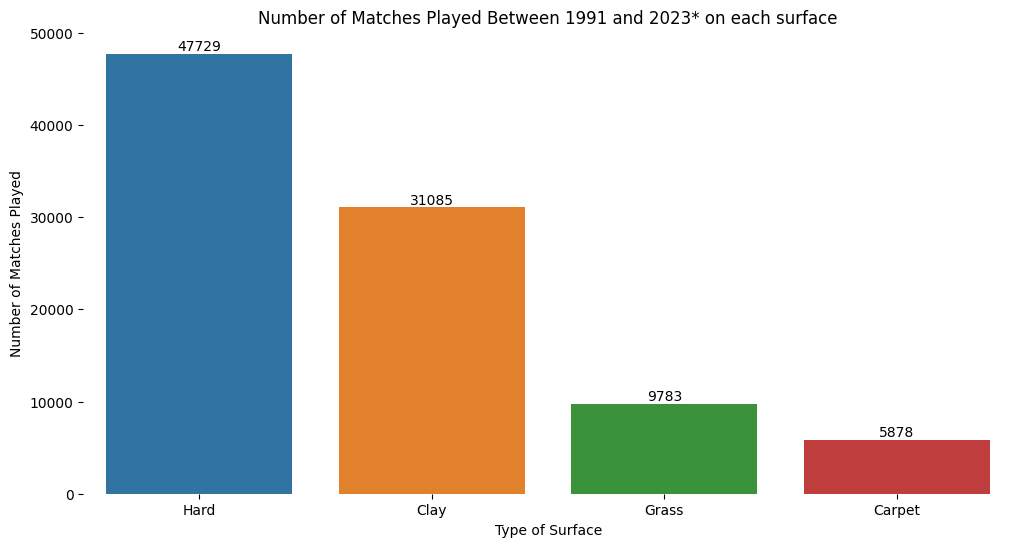

In [15]:
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)
sns.despine(left=True, bottom=True)
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")
plt.show()

### Best of 5 VS Best of 3:

Counting the number of best of 5 and best of 3 matches played:

In [16]:
combined_df.best_of.value_counts()

3    77549
5    16926
Name: best_of, dtype: int64

Plotting the number of best of 5 and best of 3 matches played:

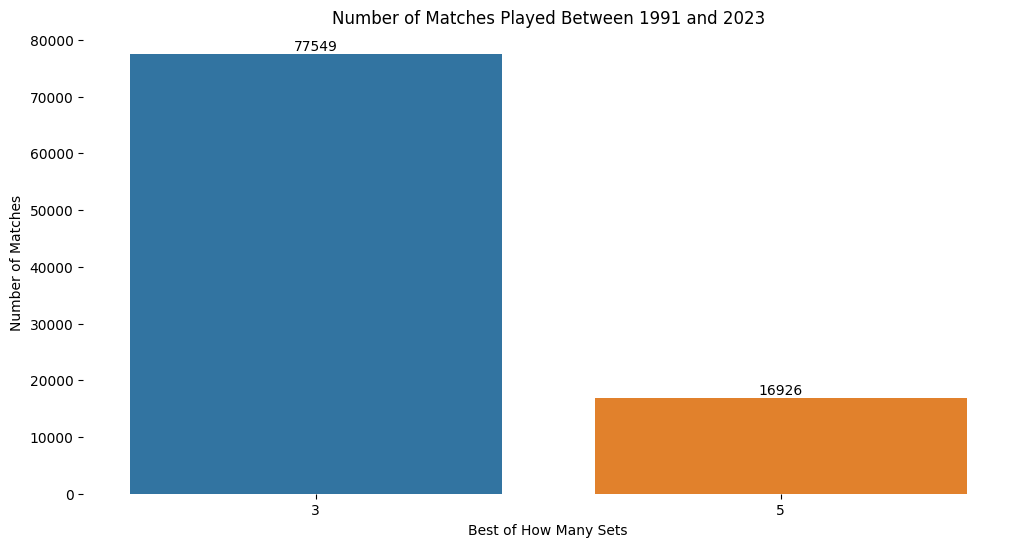

In [17]:
plt.figure(figsize=(12,6))
best_of_countplot = sns.countplot(data=combined_df, x="best_of", order=combined_df.best_of.value_counts().index)
sns.despine(left=True, bottom=True)
best_of_countplot.bar_label(best_of_countplot.containers[0], label_type='edge')
best_of_countplot.set_xlabel("Best of How Many Sets")
best_of_countplot.set_ylabel("Number of Matches")
best_of_countplot.set_title("Number of Matches Played Between 1991 and 2023")
plt.show()

In [18]:
combined_df.winner_hand.value_counts()

R    80993
L    13352
U      117
A        8
Name: winner_hand, dtype: int64

In [19]:
combined_df.loser_hand.value_counts()

R    80149
L    13969
U      306
A       27
Name: loser_hand, dtype: int64

## Numerical Variables

### Analyzing the total_points variable:

Descriptive statistics:

In [ ]:
combined_df.total_points.describe()

Skewness and Kurtosis:

In [20]:
total_points_skewness = combined_df.total_points.skew()
total_points_kurtosis = combined_df.total_points.kurtosis()

print(f"Skewness: {round(total_points_skewness, 3)}")
print(f"Kurtosis: {round(total_points_kurtosis, 3)}")

Skewness: 1.124
Kurtosis: 2.164


Plotting:

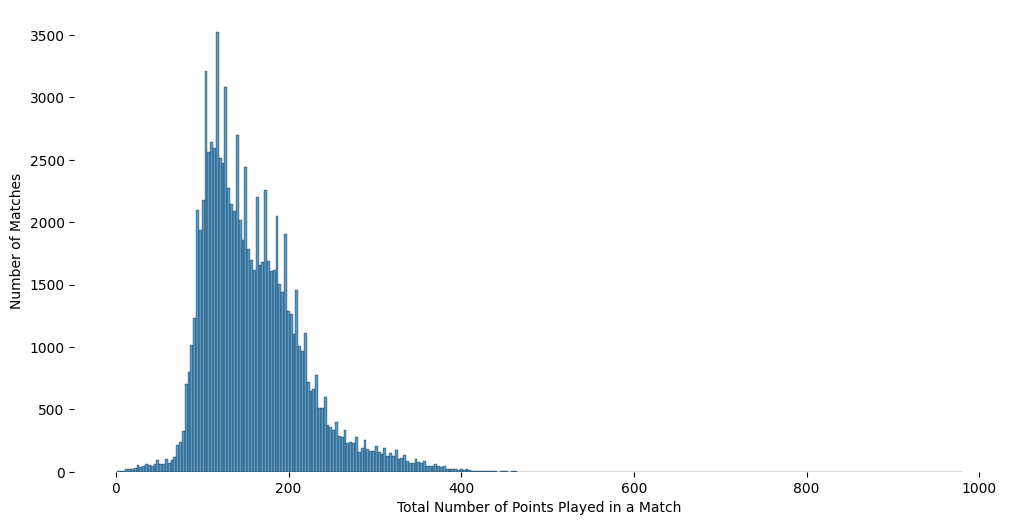

In [21]:
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")
sns.despine(left=True, bottom=True)
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")
plt.show()

### Analyzing the winner_age variable:

Descriptive statistics:

In [22]:
combined_df["winner_age"].describe()

count    94475.000000
mean        25.894353
std          3.792666
min         14.900000
25%         23.100000
50%         25.600000
75%         28.400000
max         42.700000
Name: winner_age, dtype: float64

Skewness and Kurtosis:

In [23]:
winner_age_skewness = combined_df["winner_age"].skew()
winner_age_kurtosis = combined_df["winner_age"].kurtosis()

print(f"Skewness: {round(winner_age_skewness, 3)}")
print(f"Kurtosis: {round(winner_age_kurtosis, 3)}")

Skewness: 0.413
Kurtosis: -0.092


Plotting:

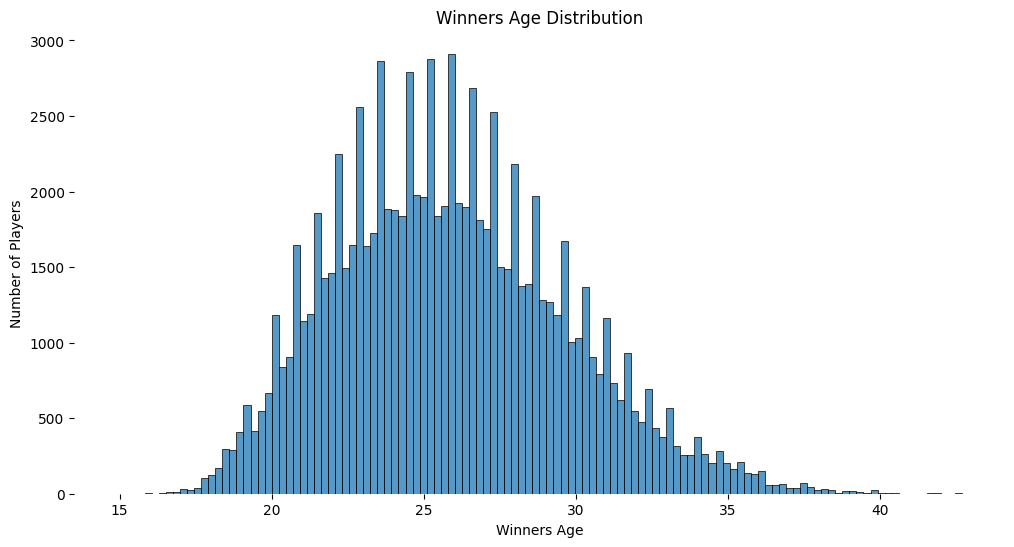

In [24]:
plt.figure(figsize=(12, 6))
winner_age_histogram = sns.histplot(data=combined_df, x="winner_age")
sns.despine(left=True, bottom=True)
winner_age_histogram.set_xlabel("Winners Age")
winner_age_histogram.set_ylabel("Number of Players")
winner_age_histogram.set_title("Winners Age Distribution")
plt.show()